In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from camera.orthographic_camera import OrthographicCamera, FollowingOrthographicCamera
from camera.perspective_camera import PerspectiveCamera, FollowingPerspectiveCamera

from voxel.activated_volume import ActivatedVolume
from geometry.clad_profile_function import GenerateParabolicCladProfile

ModuleNotFoundError: No module named 'camera'

In [2]:
# Create a volume
volume = ActivatedVolume.from_dimensions(
    dimensions=(0.008, 0.008, 0.003),  # 8mm x 8mm x 3mm
    voxel_size=0.00005,  # 50 microns
    substrate_height=0.0002  # 0.2mm substrate
)

# Generate initial track profile (no existing cross-section)
start_profile = GenerateParabolicCladProfile.generate_profile_function(
    width=0.001,  # 1mm width
    height=0.0015,  # 1.5mm height
    track_center=0.004,  # centered at 4mm in x
    cross_section=None  # First track on substrate
)

# Generate end profile with different parameters
end_profile = GenerateParabolicCladProfile.generate_profile_function(
    width=0.0015,  # 1.5mm width
    height=0.001,  # 1mm height
    track_center=0.004,  # centered at 4mm in x
    cross_section=None  # Could provide existing surface here for multi-track
)

# Add track section
volume.add_track_section(
    start_profile=start_profile,
    end_profile=end_profile,
    length_between=0.005,  # 5mm long track
    y_position=0.0015  # starting at 1.5mm in y
)

In [3]:
# Initialize field with warm substrate
temperature_field = np.full(volume.shape, 300.0)
temperature_field[volume.activated] = 500.0

# Warm up substrate voxels (z < substrate_nz) to 400K
if volume.substrate_nz > 0:
    temperature_field[:, :, :volume.substrate_nz] = 400.0

# Track end position in voxel coordinates
track_end_x = int(0.004 / volume.voxel_size[0])   # ~4 mm
track_end_y = int((0.0015 + 0.005) / volume.voxel_size[1])  # ~6.5 mm
track_end_z = int(0.001 / volume.voxel_size[2])   # ~1 mm

# Gaussian hotspot
sigma = 30
peak_temp = 1500
for i in range(volume.shape[0]):
    for j in range(volume.shape[1]):
        for k in range(volume.shape[2]):
            if volume.activated[i, j, k]:
                dist_sq = ((i - track_end_x)**2 +
                           (j - track_end_y)**2 +
                           (k - track_end_z)**2)
                temperature_field[i, j, k] += (peak_temp - 400.0) * np.exp(-dist_sq / (2 * sigma**2))


Auto Resolution: (166, 166)


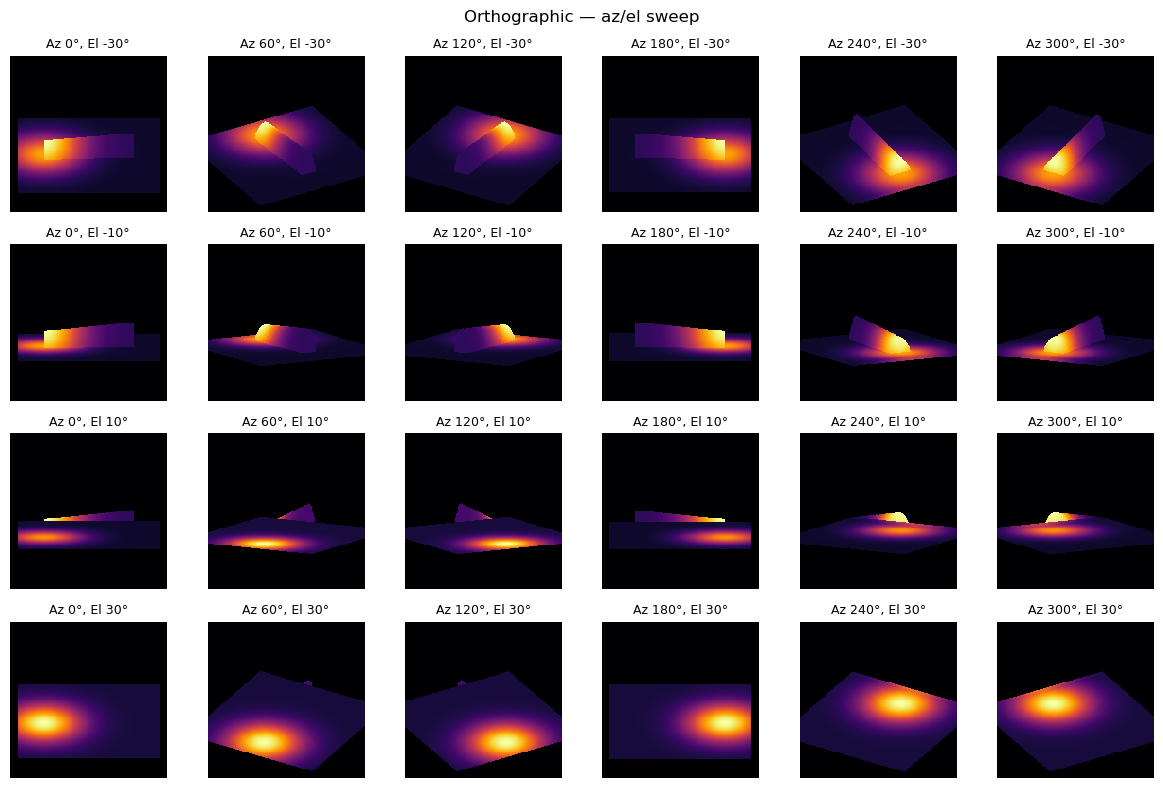

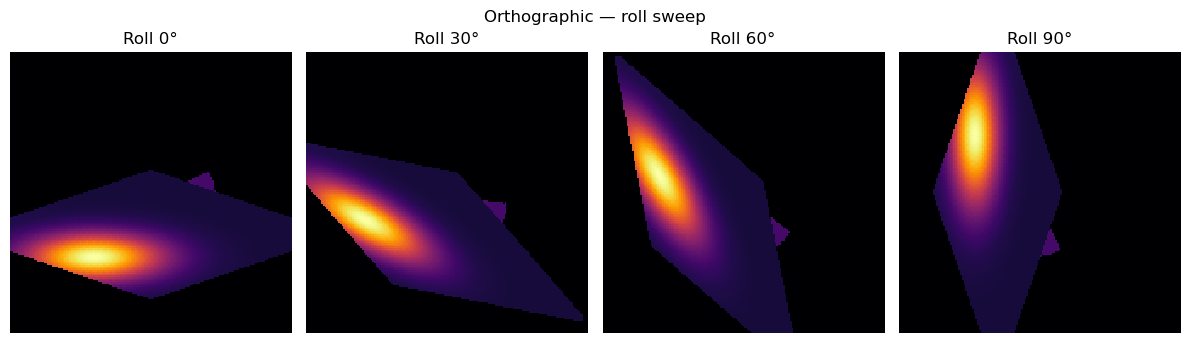

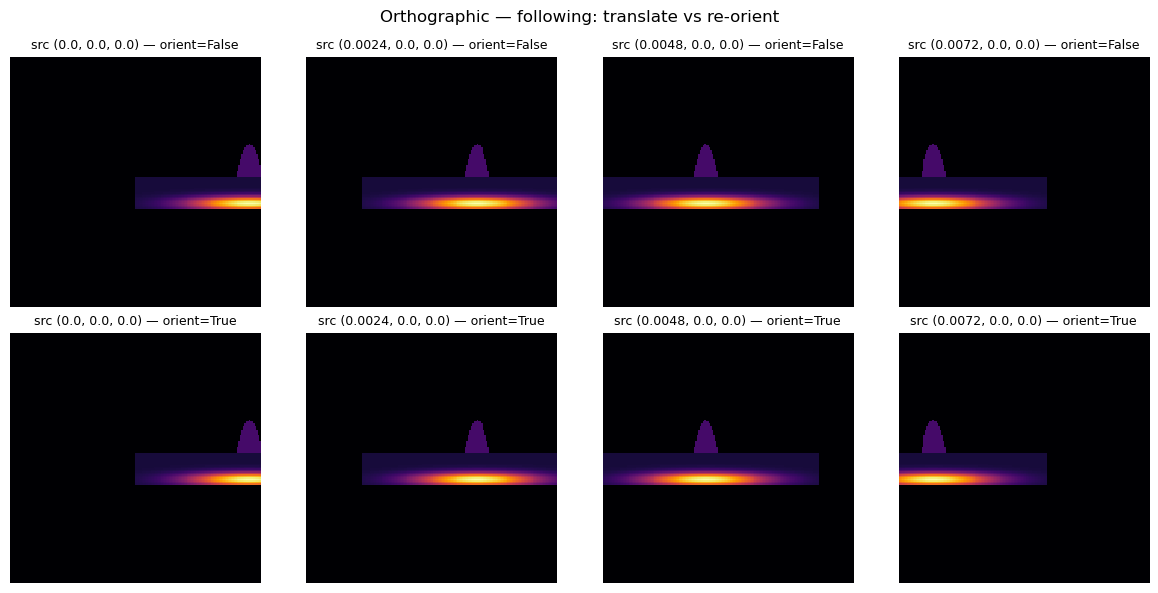

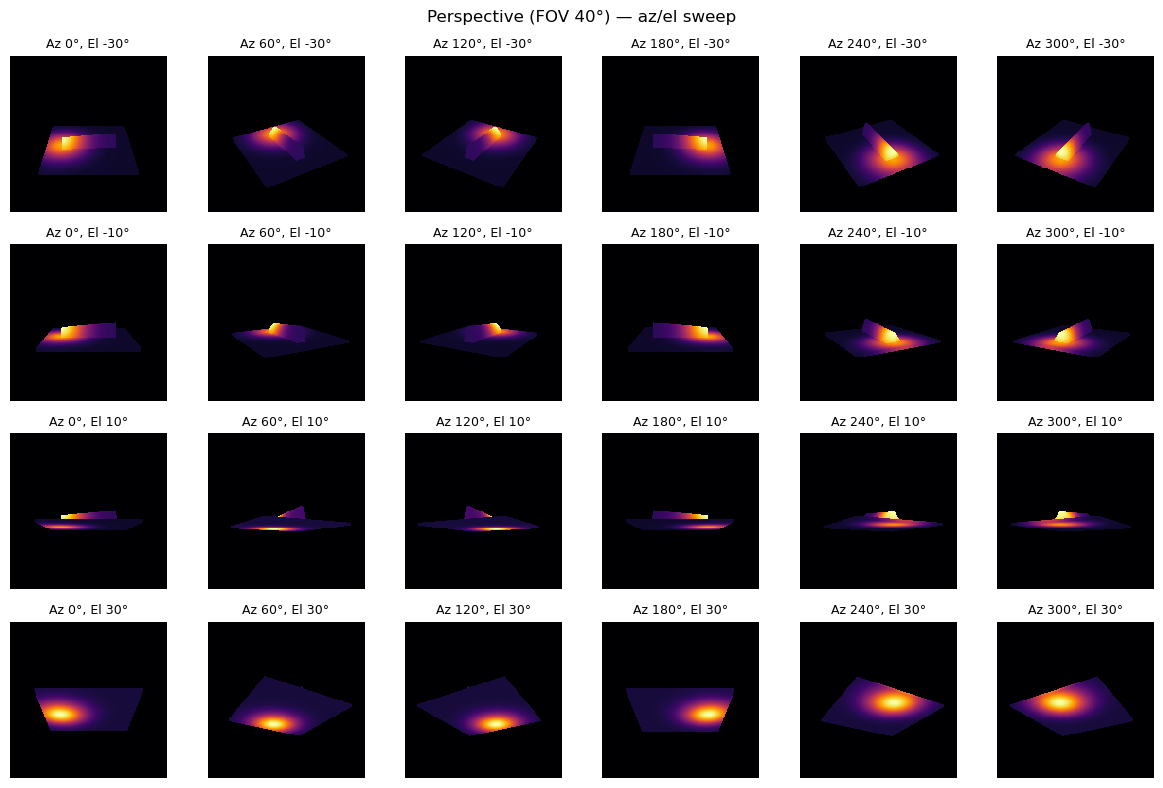

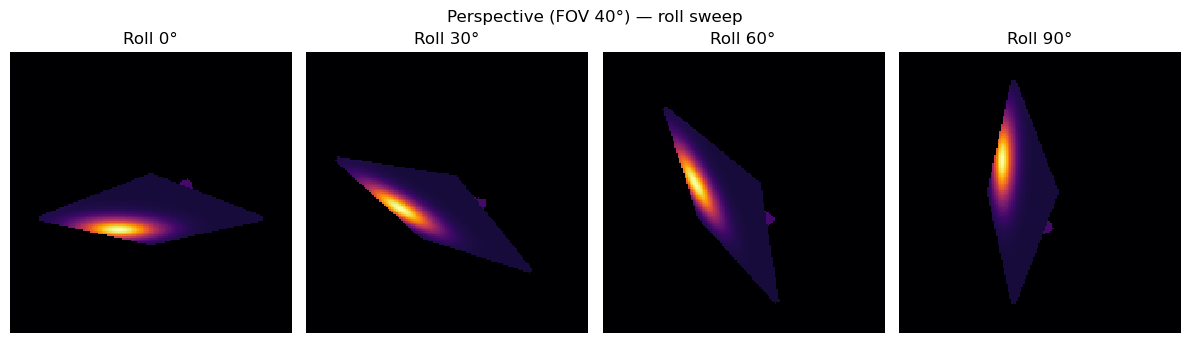

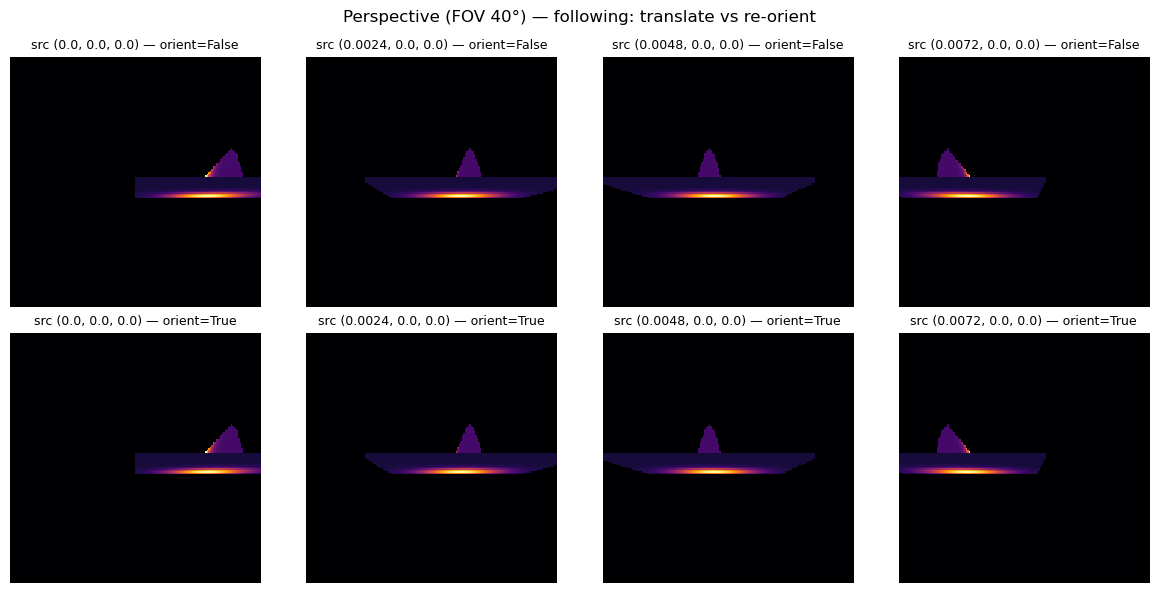

In [4]:
# ---- derive scene scale from volume ----
voxel_dx, voxel_dy, voxel_dz = volume.voxel_size  # meters/voxel
nx, ny, nz = volume.activated.shape
vol_size = np.array([nx*voxel_dx, ny*voxel_dy, nz*voxel_dz])  # meters
xy_max = float(max(vol_size[0], vol_size[1]))
center = vol_size / 2.0

# ---- choose scale-aware camera parameters (meters) ----
# Plane size: cover XY with a small margin (10%)
PLANE_SIZE = (1.1 * vol_size[0], 1.1 * vol_size[1])

# Keep pixel size ~ voxel pitch
px, py = voxel_dx, voxel_dy
RES = (max(1, int(np.ceil(PLANE_SIZE[0] / px)) - 10),
       max(1, int(np.ceil(PLANE_SIZE[1] / py)) - 10))
print("Auto Resolution:", RES)

# Camera radius: sit outside the volume, but close (2× XY extent)
RADIUS = max(0.02, 2.0 * xy_max)  # clamp to 2cm minimum so perspective isn’t degenerate

# Following cam offset: back by 1.5× extent, up by 0.5×
FOLLOW_BACK = 1.5 * xy_max
FOLLOW_UP = 0.5 * xy_max
FLOOR_ANGLE = 25.0  # deg

# Perspective FOV: moderately narrow for small scenes
FOV_Y_DEG = 40.0

# Sweeps
az_list = np.linspace(0, 360, 6, endpoint=False)
el_list = [-30, -10, 10, 30]  # gentler tilt for small targets
rolls = [0, 30, 60, 90]

def run_all_tests(Camera, FollowingCamera, label, **init_kwargs):
    # 1) Azimuth/Elevation
    fig, axes = plt.subplots(len(el_list), len(az_list), figsize=(12, 8))
    for i, el in enumerate(el_list):
        for j, az in enumerate(az_list):
            cam = Camera(plane_size=PLANE_SIZE, voxel_size_xyz=volume.voxel_size, **init_kwargs)
            cam.set_resolution(*RES)
            cam.set_from_spherical(az_deg=az, el_deg=el, radius=RADIUS, target=center)
            img, extent = cam.render_first_hit(volume.activated, temperature_field)
            ax = axes[i, j]
            ax.imshow(img.T, extent=extent, origin="lower", cmap="inferno",
                      interpolation="nearest", aspect="equal")
            ax.set_title(f"Az {az:.0f}°, El {el:.0f}°", fontsize=9)
            ax.axis("off")
    plt.suptitle(f"{label} — az/el sweep")
    plt.tight_layout()
    plt.show()

    # 2) Roll
    fig, axes = plt.subplots(1, len(rolls), figsize=(12, 3.5))
    for ax, roll in zip(axes, rolls):
        cam = Camera(plane_size=PLANE_SIZE, voxel_size_xyz=volume.voxel_size, **init_kwargs)
        cam.set_resolution(*RES)
        cam.set_from_spherical(az_deg=45, el_deg=20, roll_deg=roll, radius=RADIUS, target=center)
        img, extent = cam.render_first_hit(volume.activated, temperature_field)
        ax.imshow(img.T, extent=extent, origin="lower", cmap="inferno",
                  interpolation="nearest", aspect="equal")
        ax.set_title(f"Roll {roll}°")
        ax.axis("off")
    plt.suptitle(f"{label} — roll sweep")
    plt.tight_layout()
    plt.show()

    # 3) Following (translate only vs re-orient)
    f_cam = FollowingCamera(
        source_pos=(0.0, 0.0, 0.0),
        rel_offset_local=(0.0, -FOLLOW_BACK, FOLLOW_UP),
        floor_angle_deg=FLOOR_ANGLE,
        plane_size=PLANE_SIZE,
        voxel_size_xyz=volume.voxel_size,
        **init_kwargs
    )
    f_cam.set_resolution(*RES)

    # Move source across +X over the actual volume width
    steps = 4
    xs = np.linspace(0.0, vol_size[0]*0.9, steps)
    src_positions = [(float(x), 0.0, 0.0) for x in xs]

    fig, axes = plt.subplots(2, steps, figsize=(12, 6))

    # Row 1: translate only
    for k, src in enumerate(src_positions):
        f_cam.follow_heat_source(src, orient=False)
        img, extent = f_cam.render_first_hit(volume.activated, temperature_field)
        ax = axes[0, k]
        ax.imshow(img.T, extent=extent, origin="lower", cmap="inferno",
                  interpolation="nearest", aspect="equal")
        ax.set_title(f"src {tuple(np.round(src, 4))} — orient=False", fontsize=9)
        ax.axis("off")

    # Row 2: re-orient each step
    f_cam.follow_heat_source(src_positions[0], orient=True)
    for k, src in enumerate(src_positions):
        f_cam.follow_heat_source(src, orient=True)
        img, extent = f_cam.render_first_hit(volume.activated, temperature_field)
        ax = axes[1, k]
        ax.imshow(img.T, extent=extent, origin="lower", cmap="inferno",
                  interpolation="nearest", aspect="equal")
        ax.set_title(f"src {tuple(np.round(src, 4))} — orient=True", fontsize=9)
        ax.axis("off")

    plt.suptitle(f"{label} — following: translate vs re-orient")
    plt.tight_layout()
    plt.show()


# ---- Ortho ----
run_all_tests(
    Camera=OrthographicCamera,
    FollowingCamera=FollowingOrthographicCamera,
    label="Orthographic"
)

# ---- Perspective ----
run_all_tests(
    Camera=PerspectiveCamera,
    FollowingCamera=FollowingPerspectiveCamera,
    label=f"Perspective (FOV {FOV_Y_DEG:.0f}°)",
    fov_y_deg=FOV_Y_DEG
)


In [5]:
# -------------------------------
# Helpers (size-aware parameters)
# -------------------------------
voxel_dx, voxel_dy, voxel_dz = volume.voxel_size
nx, ny, nz = volume.activated.shape
vol_size = np.array([nx*voxel_dx, ny*voxel_dy, nz*voxel_dz], dtype=float)
center = vol_size / 2.0

def plane_and_res(voxel_size_xyz, cover_margin=1.1):
    """Return (PLANE_SIZE, RES) with your artifact-safe RES formula."""
    PLANE_SIZE = (cover_margin * vol_size[0], cover_margin * vol_size[1])
    px, py, _ = voxel_size_xyz
    RES = (
        max(1, int(np.ceil(PLANE_SIZE[0] / px)) - 10),
        max(1, int(np.ceil(PLANE_SIZE[1] / py)) - 10)
    )
    return PLANE_SIZE, RES

BASE_PLANE_SIZE, BASE_RES = plane_and_res(volume.voxel_size, cover_margin=1.1)

# Camera distances proportional to scene scale
xy_max = float(max(vol_size[0], vol_size[1]))
BASE_RADIUS = max(0.02, 2.0 * xy_max)         # >= 2 cm to avoid pathological perspective
FOV_Y_DEG = 40.0                              # reasonable for cm-scale scenes

# ---------------------------------------
# Synthetic volumes for controlled sweeps
# ---------------------------------------
def make_synthetic_volume(base_shape, frac_active, rng=None):
    """
    Create a synthetic (activated, temperature) pair with a controlled
    number of active voxels. Temperatures are random-but-stable.
    """
    if rng is None:
        rng = np.random.default_rng(42)
    nx, ny, nz = base_shape
    total = nx*ny*nz
    k = max(0, min(total, int(round(frac_active * total))))
    A = np.zeros((nx, ny, nz), dtype=bool)
    if k > 0:
        # sample k unique positions
        idx = rng.choice(total, size=k, replace=False)
        x = idx // (ny*nz)
        y = (idx // nz) % ny
        z = idx % nz
        A[x, y, z] = True
    # temperatures on active voxels; ambient elsewhere will be handled by renderer
    T = np.full((nx, ny, nz), 300.0, dtype=np.float32)
    if k > 0:
        T[A] = 300.0 + 100.0 * rng.random(k)  # 300..400K
    return A, T

# ---------------------------------------
# Camera factory to keep setup identical
# ---------------------------------------
def make_camera(camera_cls, plane_size, res, fov_y_deg=None):
    kwargs = dict(plane_size=plane_size, voxel_size_xyz=volume.voxel_size)
    if fov_y_deg is not None:
        cam = camera_cls(fov_y_deg=fov_y_deg, **kwargs)
    else:
        cam = camera_cls(**kwargs)
    cam.set_resolution(*res)
    cam.set_from_spherical(az_deg=45, el_deg=20, radius=BASE_RADIUS, target=center)
    return cam

# ---------------------------------------
# Benchmark core
# ---------------------------------------
def time_render(cam, A, T, repeats=5, warmup=1):
    # warm-up
    for _ in range(warmup):
        cam.render_first_hit(A, T)
    # timing
    t0 = time.perf_counter()
    for _ in range(repeats):
        cam.render_first_hit(A, T)
    t1 = time.perf_counter()
    return (t1 - t0) / repeats

def run_benchmarks():
    rng = np.random.default_rng(123)
    base_shape = (nx, ny, nz)

    # Factors:
    # - sparsity (fraction of active voxels)
    # - resolution scale (multiply base RES)
    # - camera type (orthographic / perspective)
    sparsities = [0.02, 0.05, 0.1, 0.3, 1.0]     # from very sparse to full
    res_scales = [0.5, 1.0, 2.0, 4.0]            # pixel count factor ~ scale^2
    camera_types = [
        ("ortho", OrthographicCamera, None),
        ("persp", PerspectiveCamera, FOV_Y_DEG),
    ]

    rows = []
    for cam_name, cam_cls, fov in camera_types:
        for s in sparsities:
            A, T = make_synthetic_volume(base_shape, s, rng=rng)

            for scale in res_scales:
                # scale resolution but keep plane size fixed → changes pixel pitch
                W = max(1, int(round(BASE_RES[0] * scale)))
                H = max(1, int(round(BASE_RES[1] * scale)))
                res = (W, H)

                cam = make_camera(cam_cls, BASE_PLANE_SIZE, res, fov_y_deg=fov)
                t = time_render(cam, A, T, repeats=7, warmup=2)

                rows.append(dict(
                    camera=cam_name,
                    sparsity=s,
                    N_active=int(A.sum()),
                    N_total=A.size,
                    W=W, H=H, Pixels=W*H,
                    time_s=t
                ))

    df = pd.DataFrame(rows)
    return df

df = run_benchmarks()
print(df.head())

# -----------------------------------------------------
# Fit simple models: t ≈ a*N_active + b*Pixels + c
# and multiplicative: log t ≈ α + β log N_active + γ log Pixels
# -----------------------------------------------------
def fit_linear_model(df_cam):
    X = np.column_stack([
        df_cam["N_active"].values.astype(float),
        df_cam["Pixels"].values.astype(float),
        np.ones(len(df_cam))
    ])
    y = df_cam["time_s"].values.astype(float)
    coef, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ coef
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return coef, r2

def fit_log_model(df_cam):
    # guard against zeros
    mask = (df_cam["N_active"] > 0) & (df_cam["Pixels"] > 0) & (df_cam["time_s"] > 0)
    d = df_cam.loc[mask].copy()
    X = np.column_stack([
        np.log(d["N_active"].values.astype(float)),
        np.log(d["Pixels"].values.astype(float)),
        np.ones(len(d))
    ])
    y = np.log(d["time_s"].values.astype(float))
    coef, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ coef
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return coef, r2

summary = []
for cam_name in df["camera"].unique():
    d = df[df["camera"] == cam_name]
    (a, b, c), r2_lin = fit_linear_model(d)
    (beta_na, beta_px, alpha), r2_log = fit_log_model(d)
    summary.append({
        "camera": cam_name,
        "linear: t ≈ a*N_active + b*Pixels + c": (a, b, c),
        "linear R^2": r2_lin,
        "log: t ≈ exp(α) * N_active^βna * Pixels^βpx": (alpha, beta_na, beta_px),
        "log R^2": r2_log
    })

pd.DataFrame(summary)


  camera  sparsity  N_active  N_total    W    H  Pixels    time_s
0  ortho      0.02     30720  1536000   83   83    6889  0.010588
1  ortho      0.02     30720  1536000  166  166   27556  0.011031
2  ortho      0.02     30720  1536000  332  332  110224  0.011404
3  ortho      0.02     30720  1536000  664  664  440896  0.011775
4  ortho      0.05     76800  1536000   83   83    6889  0.020599


,camera,linear: t ≈ a*N_active + b*Pixels + c,linear R^2,log: t ≈ exp(α) * N_active^βna * Pixels^βpx,log R^2
0,ortho,"(1.802499513616342e-07, 2.203975978759637e-08,...",0.988239,"(-13.575543451414319, 0.8457027596657032, 0.02...",0.997609
1,persp,"(1.9988272807336302e-07, 2.9057875938835574e-0...",0.989910,"(-14.005118020771173, 0.8735380334417514, 0.04...",0.997196


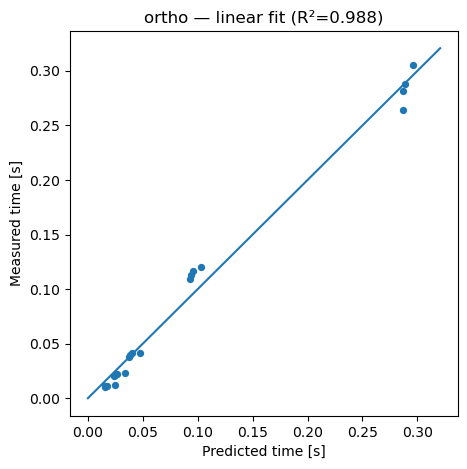

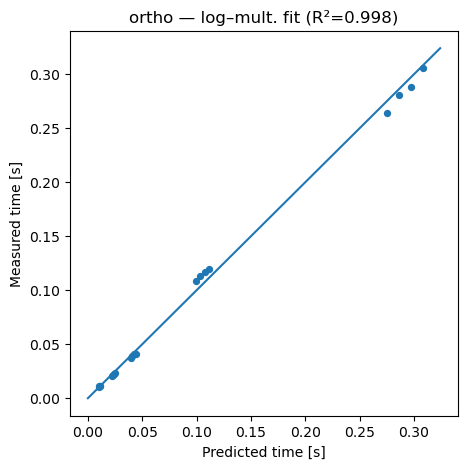

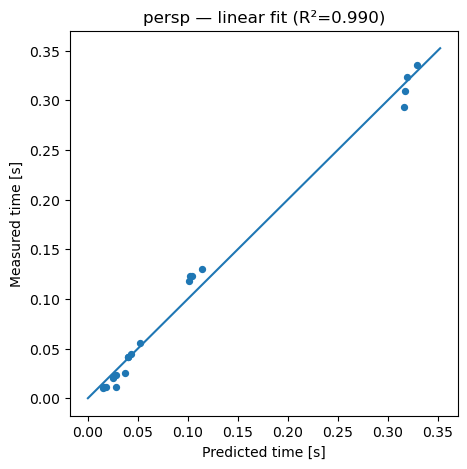

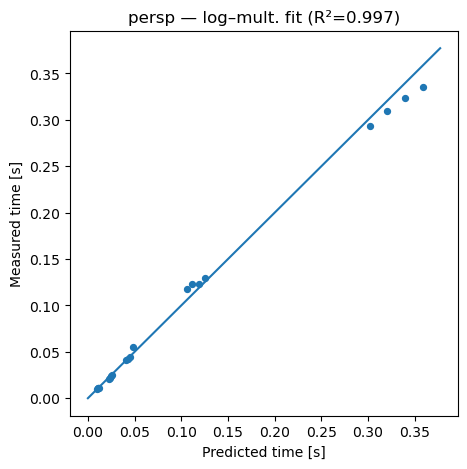

In [6]:
def plot_fit(df, cam_name, model="linear"):
    d = df[df["camera"] == cam_name].copy()
    if model == "linear":
        (a, b, c), r2 = fit_linear_model(d)
        y_hat = a*d["N_active"].values + b*d["Pixels"].values + c
        title = f"{cam_name} — linear fit (R²={r2:.3f})"
    else:
        (beta_na, beta_px, alpha), r2 = fit_log_model(d)
        y_hat = np.exp(alpha) * (d["N_active"].values ** beta_na) * (d["Pixels"].values ** beta_px)
        title = f"{cam_name} — log–mult. fit (R²={r2:.3f})"

    plt.figure(figsize=(5,5))
    plt.scatter(y_hat, d["time_s"].values, s=18)
    lim = [0, max(np.max(y_hat), np.max(d["time_s"].values))*1.05]
    plt.plot(lim, lim)
    plt.xlabel("Predicted time [s]")
    plt.ylabel("Measured time [s]")
    plt.title(title)
    plt.show()

# Plot both models per camera
for cam in df["camera"].unique():
    plot_fit(df, cam, model="linear")
    plot_fit(df, cam, model="log")


In [7]:
df

,camera,sparsity,N_active,N_total,W,H,Pixels,time_s
0,ortho,0.02,30720,1536000,83,83,6889,0.010588
1,ortho,0.02,30720,1536000,166,166,27556,0.011031
2,ortho,0.02,30720,1536000,332,332,110224,0.011404
3,ortho,0.02,30720,1536000,664,664,440896,0.011775
4,ortho,0.05,76800,1536000,83,83,6889,0.020599
5,ortho,0.05,76800,1536000,166,166,27556,0.021212
6,ortho,0.05,76800,1536000,332,332,110224,0.022190
7,ortho,0.05,76800,1536000,664,664,440896,0.023201
8,ortho,0.10,153600,1536000,83,83,6889,0.037330
9,ortho,0.10,153600,1536000,166,166,27556,0.039433
